In [1]:
# Importing Libraries
import numpy as np
import pandas as pd

In [2]:
# Reading Iris Dataset from Local Drive
from google.colab import files
uploaded = files.upload()

Saving iris.csv to iris.csv


In [3]:
iris_data = pd.read_csv("iris.csv") 

In [4]:
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# Decision Tree 
# Node Class
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [6]:
# Decision Tree 
# Tree Class
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


In [7]:
# Train-Test Split
from sklearn.model_selection import train_test_split


In [8]:
X = iris_data.iloc[:, :-1].values
Y = iris_data.iloc[:, -1].values.reshape(-1,1)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [10]:
# Fit The Decision Tree Classifier on Training Dataset
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)


In [11]:
# Fit patterns in data
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_2 <= 1.9 ? 0.33741385372714494
 left:setosa
 right:X_3 <= 1.5 ? 0.427106638180289
  left:X_2 <= 4.9 ? 0.05124653739612173
    left:versicolor
    right:virginica
  right:X_2 <= 5.0 ? 0.019631171921475288
    left:X_1 <= 2.8 ? 0.20833333333333334
        left:virginica
        right:versicolor
    right:virginica


In [12]:
Y_pred = classifier.predict(X_test) 


In [13]:
# Test The Model on Test Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  #for visualizing tree 

In [14]:
accuracy_score(Y_test, Y_pred)


0.9333333333333333

In [15]:
print("Classification Report - \n", classification_report(Y_test, Y_pred))

Classification Report - 
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         9
  versicolor       0.91      0.91      0.91        11
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.93      0.93      0.93        30



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
# for encoding

In [17]:
cm = confusion_matrix(Y_test, Y_pred)
cm

array([[ 9,  0,  0],
       [ 0, 10,  1],
       [ 0,  1,  9]])

Text(0.5, 48.29999999999998, 'Predicted label')

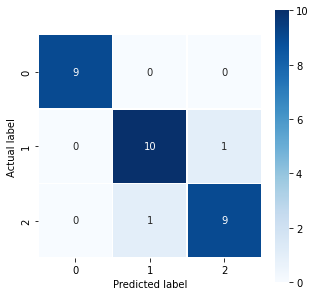

In [18]:
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# all_sample_title = 'Accuracy Score: {0}'.format(classifier.score(X_test, Y_test))
# plt.title(all_sample_title, size = 15)